# Analysis of selection favoring multiple subclones (related to Figure 4)

In [1]:
from __future__ import division
import sys
import os
import time
import copy
import pickle
import glob
import itertools

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

import ete3

output_dir = "outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9", "#D55E00", "#009E73"]

# Load data

In [2]:
# Lineage dynamics data
df_expanded = pd.read_csv("data/df_expanded.filtered.csv", index_col=0)
print "Lineages"
print "Expanded", df_expanded.shape[0]

Lineages
Expanded 87


In [3]:
# Metrics of selection
df_metrics = pd.read_csv("data/df_metrics_expanded.csv", index_col=0)
df_metrics.head()

,label_dynamics,num_seq,H,H_pvalue_kingman,D,D_pvalue_kingman
lineage_uid,,,,,,
70201010000000001,Vaccine-responsive,9166,-14.499747,0.000571,0.473259,0.043936
20201010000000001,Vaccine-responsive,15632,18.579027,1.000000,-0.914991,0.749164
20201010000000267,Vaccine-responsive,5722,17.182397,1.000000,-1.515903,0.984100
60201010000000781,Vaccine-responsive,6943,3.886945,0.999978,0.005984,0.125166
20201010000000362,Vaccine-responsive,6586,23.854739,1.000000,-0.621677,0.617446


# Functions for detecting selected subclones

In [4]:
def name_internal_nodes(T):
    i = 1
    for node in T.traverse():
        if not node.is_leaf():
            node.name = str(i) + "_"
            i += 1
    return None

def find_selected_subclones_cached(lineage_uid, T, annotations_FayAndWusH,
                                   pvalue_cutoff=0.05):
    # Traverse tree and keep subclones with significant Fay and Wu's H
    
    hits = []
    
    def stop(node):
        if node.name == "germline": return False
        if node.name == "1_": return False
        if node.is_leaf(): return True
        if len(node) < 100:
            # print "Stopping, branch too small", node.name, len(node)
            return True
        elif annotations_FayAndWusH[lineage_uid].loc[node.name]["pvalue_kingman"] < pvalue_cutoff:
            print "Hit branch", node.name
            return True
        else:
            return False
        
    # Traverse tree and find selected nodes
    for node in T.traverse("levelorder", is_leaf_fn=stop):
        if node.is_leaf(): continue
        if node.name == "1_": continue
        if len(node) < 100: continue # distributions of H under BSC and Kingman become hard to distinguish near N = 100
        
        if annotations_FayAndWusH[lineage_uid].loc[node.name]["pvalue_kingman"] < pvalue_cutoff:
            myHit = annotations_FayAndWusH[lineage_uid].loc[node.name]
            hits.append(myHit)
    
    return hits

# Traverse tree and keep subclones with significant Fay and Wu's H
# Report number of comparisons

def find_selected_subclones_cached_Ncomparisons(lineage_uid, T, annotations_FayAndWusH, pvalue_cutoff=0.05):

    hits = []
    
    def stop(node):
        if node.name == "germline": return False
        if node.name == "1_": return False
        if node.is_leaf(): return True
        if annotations_FayAndWusH[lineage_uid].loc[node.name]["pvalue_kingman"] < pvalue_cutoff:
            # print "Hit branch", node.name
            return True
        elif len(node) < 100:
            # print "Stopping branch (too small)", node.name
            return True
        else:
            return False

    N_comparisons = 0
    # Traverse tree and find selected nodes
    for node in T.traverse("levelorder", is_leaf_fn=stop):
        if node.is_leaf(): continue
        if node.name == "1_": continue
        if len(node) < 100: continue # distributions of H under BSC and Kingman become hard to distinguish near N = 100
            
        N_comparisons += 1
        
        if annotations_FayAndWusH[lineage_uid].loc[node.name]["pvalue_kingman"] < pvalue_cutoff:
            myHit = annotations_FayAndWusH[lineage_uid].loc[node.name]
            hits.append(myHit)
    
    return hits, N_comparisons

def find_selected_subclones_cached_dynamicFDR(lineage_uid, T, annotations_FayAndWusH,
                                              total_FDR_cutoff=0.05, max_iterations=10):
    N_comparisons = 1
    N_comparisons_prev = 0
    iterations = 0
    while N_comparisons != N_comparisons_prev:
        iterations += 1
        N_comparisons_prev = N_comparisons
        my_pvalue_cutoff = total_FDR_cutoff / float(N_comparisons_prev)
        hits, N_comparisons = find_selected_subclones_cached_Ncomparisons(lineage_uid, T,
                                                                          annotations_FayAndWusH,
                                                                          pvalue_cutoff=my_pvalue_cutoff)
        if iterations >= max_iterations:
            print "No convergence in", max_iterations, "iterations"
            print "Current N_comparisons", N_comparisons
            print "Current len(hits)", len(hits)
            return hits, N_comparisons
        
        if N_comparisons == 0:
            print "No comparisons made"
            return hits, N_comparisons
        
    return hits, N_comparisons

# Load phylogeny data, annotations of Fay and Wu's H for each branch

In [5]:
# Load annotations
annotations_FayAndWusH = {}
infiles = glob.glob("/local10G/rfhorns/Bcell/flu_highres/trees/*/annotation*.csv")
for infile in infiles:
    if "fitnessMutations" in infile or "repair_align" in infile: continue
    lineage_uid = int(infile.split("/")[-2])
    df_annotation = pd.read_csv(infile, index_col=0, header=0)
    annotations_FayAndWusH[lineage_uid] = df_annotation

In [6]:
# Load trees
trees = {}
infiles = glob.glob("/local10G/rfhorns/Bcell/flu_highres/trees/*/fasttree.rep.nwk")
for infile in infiles:
    if "fitnessMutations" in infile or "repair_align" in infile: continue
    lineage_uid = int(infile.split("/")[-2])
    T = ete3.Tree(infile, format=1)
    name_internal_nodes(T)
    trees[lineage_uid] = T

# Detect subclones with evidence for selection in all lineages

In [7]:
# Test one lineage
lineage_uid_test = 60201010000027486
print len(trees[lineage_uid_test]), "leaves"
hits = find_selected_subclones_cached(lineage_uid_test, trees[lineage_uid_test], annotations_FayAndWusH)

1387 leaves
Hit branch 10_
Hit branch 86_
Hit branch 87_
Hit branch 125_
Hit branch 188_


In [8]:
# Run all lineages
subclones_selected = {}
for lineage_uid in df_expanded.index:
    print lineage_uid
    if lineage_uid not in annotations_FayAndWusH: continue
    subclones_selected[lineage_uid] = find_selected_subclones_cached_dynamicFDR(lineage_uid, trees[lineage_uid],
                                                                                annotations_FayAndWusH,
                                                                                total_FDR_cutoff=0.01, max_iterations=10)

70201010000000001
20201010000000001
20201010000000267
60201010000000781
20201010000000362
60201010000000001
60201010000000054
80201010000000675
60201010000000583
20201010000001265
80201010000000955
30201010000001023
No comparisons made
70201010000002740
60201010000090044
70201010000003546
80201010000027222
70201010000012214
60201010000007307
80201010000007151
60201010000022835
80201010000005517
80201010000016678
70201010000006943
70201010000000214
60201010000004642
70201010000021108
30201010000002298
No comparisons made
60201010000003720
80201010000038799
80201010000030826
70201010000008237
70201010000009999
60201010000001694
80201010000061255
No comparisons made
70201010000023370
80201010000047325
60201010000028794
60201010000078881
80201010000053829
70201010000023729
60201010000023648
70201010000025803
60201010000026351
70201010000018962
60201010000016203
80201010000021442
70201010000013215
No comparisons made
60201010000008878
70201010000033953
80201010000043910
60201010000000561
60

In [10]:
# Get number of subclones selected
num_subclones_selected = [len(x[0]) for x in subclones_selected.values()]

# Add data to dataframe
df_metrics["num_subclones_selected"] = 0
df_metrics["num_subclones_selected"].loc[subclones_selected.keys()] = num_subclones_selected

# Resort dataframe
df_metrics.sort_values(by="num_subclones_selected", ascending=True, inplace=True)

/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Plot number of subclones selected

Fraction with >0 selected 0.241379310345
Fraction with >1 selected 0.0689655172414
9


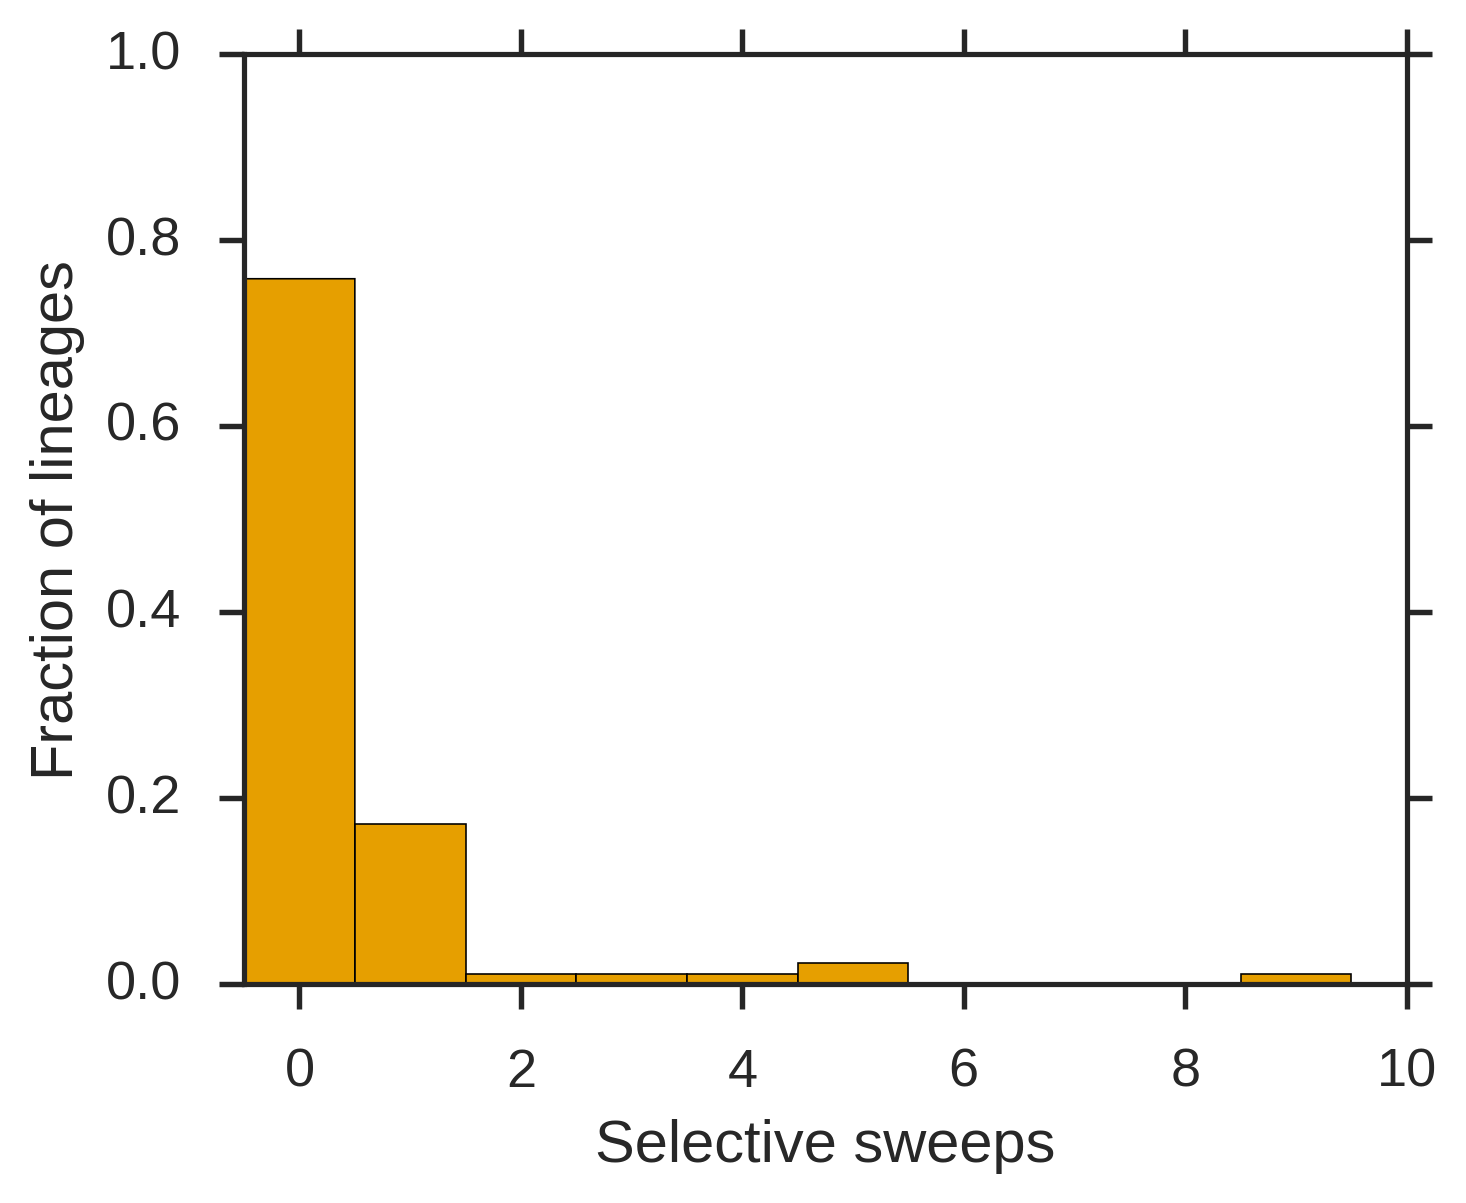

In [11]:
# All lineages (doesn't make sense to consider all lineages, as some are too small for us to detect selection in subclones)

data = df_metrics["num_subclones_selected"]
bins = np.arange(0, max(data)+2) - 0.5

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(data, weights=np.ones_like(data)/len(data), bins=bins, color=myColors[0])
ax.set_xlim(left=-0.5)
# ax.set_ylim(0,50)
ax.set_ylim(0,1)
ax.set_xlabel("Selective sweeps")
ax.set_ylabel("Fraction of lineages")
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
# save_figure(fig, "SubcloneSelection_Fraction",  output_dir, output_suffix, output_formats, savefig_args)

print "Fraction with >0 selected", sum(data > 0) / len(data)
print "Fraction with >1 selected", sum(data > 1) / len(data)
print max(data)

Fraction with >0 selected 0.52
Fraction with >1 selected 0.24
9


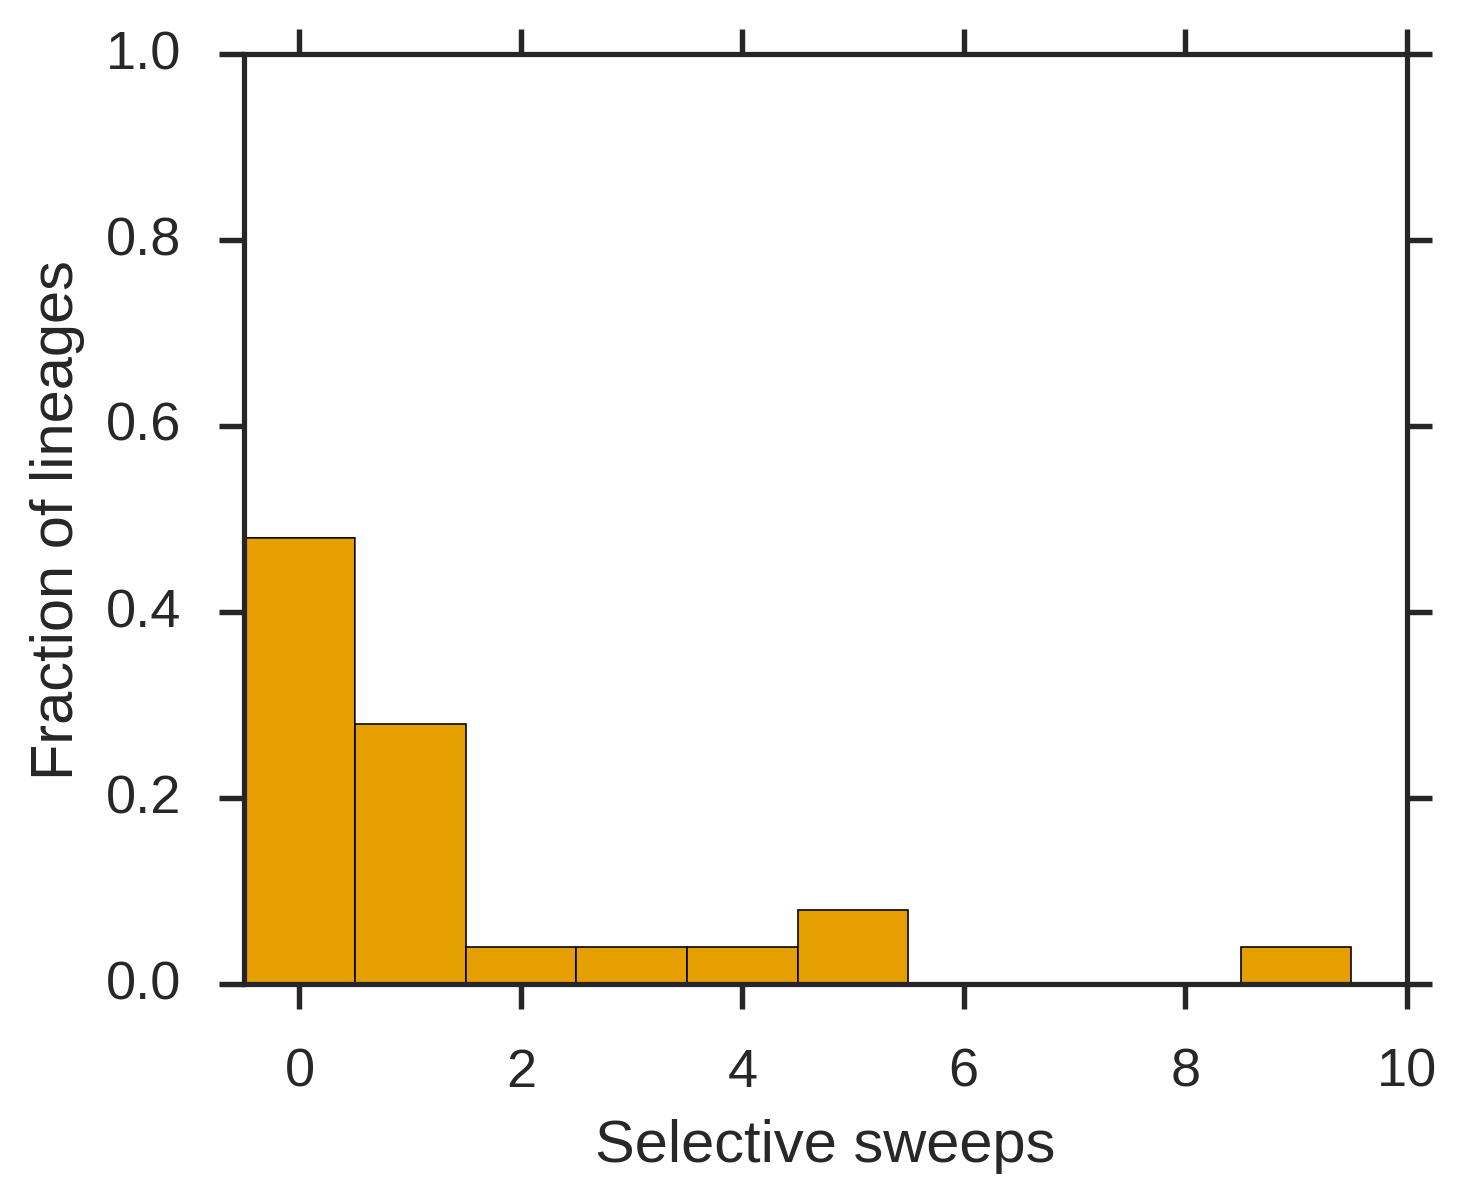

In [12]:
# Large lineages

subset = df_metrics.loc[df_metrics["num_seq"] > 1000]
data = subset["num_subclones_selected"]
bins = np.arange(0, max(data)+2) - 0.5

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(data, weights=np.ones_like(data)/len(data), bins=bins, color=myColors[0])
ax.set_xlim(left=-0.5)
# ax.set_ylim(0,50)
ax.set_ylim(0,1)
ax.set_xlabel("Selective sweeps")
ax.set_ylabel("Fraction of lineages")
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
# save_figure(fig, "SubcloneSelection_LargeLineages_Fraction",  output_dir, output_suffix, output_formats, savefig_args)

print "Fraction with >0 selected", sum(data > 0) / len(data)
print "Fraction with >1 selected", sum(data > 1) / len(data)
print max(data)

# Plot lineage size versus subclones selected

(0.41486792489560159, 0.039195686962742962)


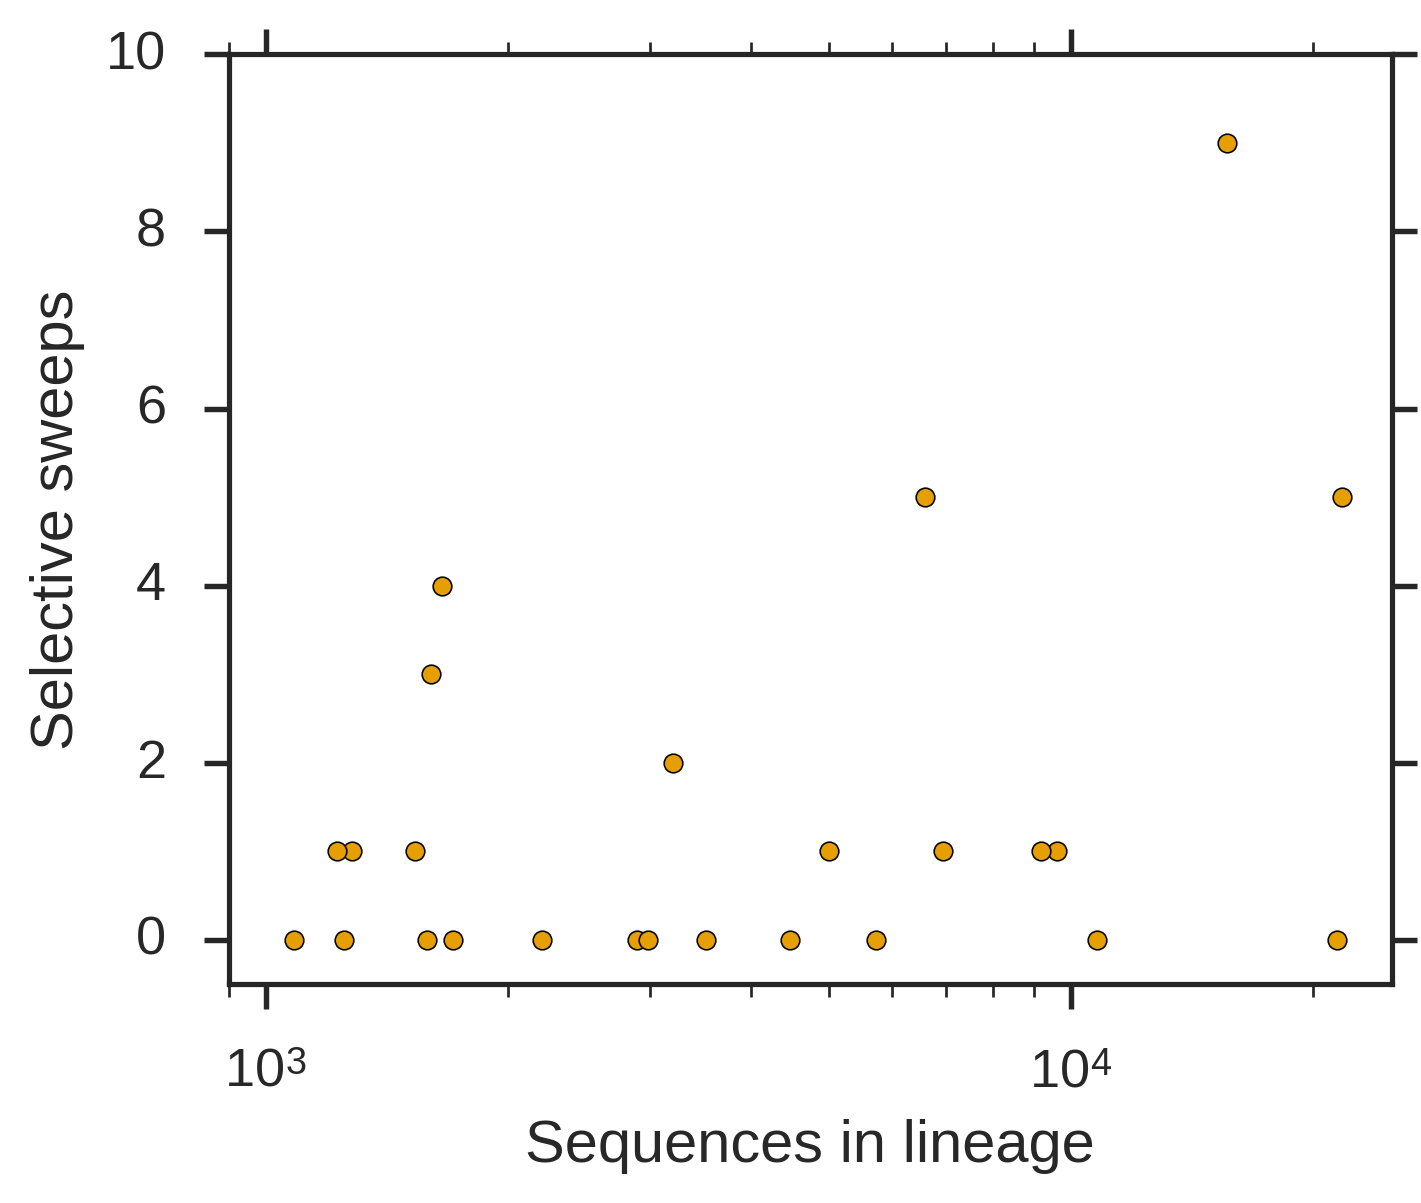

In [13]:
subset = df_metrics.loc[df_metrics["num_seq"] > 1000]
X = subset["num_seq"]
Y = subset["num_subclones_selected"]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(X, Y, c=myColors[0])
ax.set_xlim(left=900)
ax.set_ylim(bottom=-0.5)
ax.set_xscale("log")
ax.set_xlabel("Sequences in lineage")
ax.set_ylabel("Selective sweeps")
# save_figure(fig, "SubcloneSelection_LargeLineages_ScatterSize",  output_dir, output_suffix, output_formats, savefig_args)

print scipy.stats.pearsonr(X, Y)

# Plot Fay and Wu's H for lineages with varying subclones selected

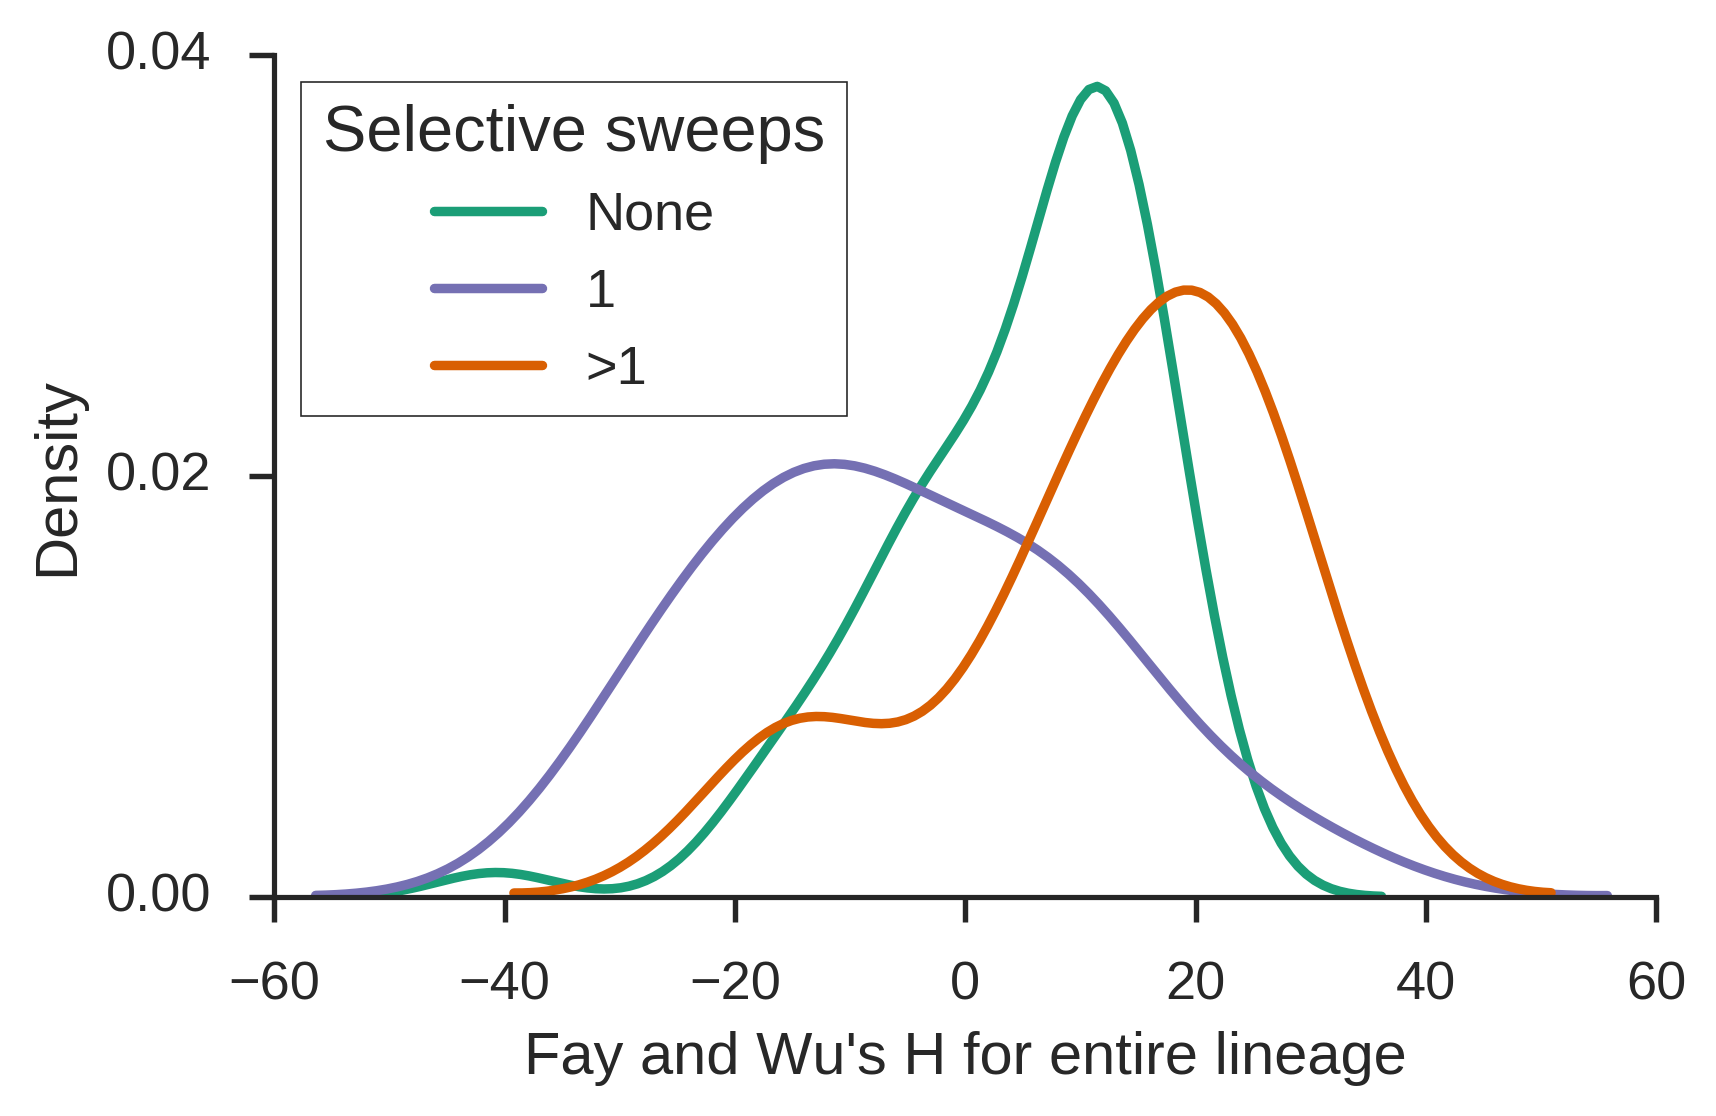

In [14]:
Z0 = df_metrics.loc[df_metrics["num_subclones_selected"] == 0]["H"]
Z1 = df_metrics.loc[df_metrics["num_subclones_selected"] == 1]["H"]
Z2 = df_metrics.loc[df_metrics["num_subclones_selected"] > 1]["H"]
Z3 = df_metrics["H"]

fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.kdeplot(Z0, ax=ax, label="None", c="#1b9e77")
sns.kdeplot(Z1, ax=ax, label="1", c="#7570b3")
sns.kdeplot(Z2, ax=ax, label=">1", c="#d95f02")
# sns.kdeplot(Z2, ax=ax, label="All lineages", c="#d95f02")
ax.set_yticks([0, 0.02, 0.04])
ax.set_xlabel("Fay and Wu's H for entire lineage")
ax.set_ylabel("Density")
ax.legend(loc="upper left", title="Selective sweeps", frameon=True)
sns.despine()
plt.tight_layout()
save_figure(fig, "SubcloneSelection_FayAndWusH", output_dir, output_suffix, output_formats, savefig_args)